In [2]:
!export JAX_PLATFORMS=cpu
import tszpower
from classy_sz import Class as Class_sz
import jax
import jax.numpy as jnp 
import numpy as np
import torch
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
from sbi.analysis import pairplot
# from sbi.inference import NPE
from sbi.inference import NLE
# from sbi.inference import FMPE
import matplotlib.pyplot as plt

2025-02-18 12:11:57.858024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739880717.866224 2421859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739880717.868594 2421859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1739880722.429390 2421859 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/data/vault/lx256/envs/sz_clusters/lib64/python3.9/site-packages/jax/_

In [3]:
low = torch.tensor([2.5,   0.02,  0.11, 55.,  0.94, 1.0, 0.0, 0.0, 0.0])
high = torch.tensor([3.5, 0.025, 0.13, 90.,  1.0,  2.0, 5.0, 5.0, 5.0])
prior = BoxUniform(low=low, high=high)
data_file = np.loadtxt("data/data_ps-ell-y2-erry2_total-planck-collab-15.txt")
x_o = data_file[:, 1]
# x_o

In [4]:
num_rounds = 5
# num_sims = 1000  # as before
inference = NLE(prior)

for round_idx in range(1, num_rounds + 1):
    print(f"Processing round {round_idx}")
    
    # Load simulation data saved in previous rounds
    theta = torch.load(f"sbi_sim_data/theta_round{round_idx}_1k.pt")
    x = torch.load(f"sbi_sim_data/x_round{round_idx}_1k.pt")

    _ = inference.append_simulations(theta, x).train(show_train_summary=True)   
    posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                          mcmc_parameters={"num_chains": 20,
                                                           "thin": 5})
    proposal = posterior.set_default_x(x_o)

Processing round 1


/tmp/ipykernel_2421859/1991749906.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta = torch.load(f"sbi_sim_data/theta_round{round_idx}_1k.pt")
/tmp/ipykernel_2421859

 Neural network successfully converged after 640 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 640
        Best validation performance: -57.6634
        -------------------------
        
Processing round 2


/tmp/ipykernel_2421859/1991749906.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta = torch.load(f"sbi_sim_data/theta_round{round_idx}_1k.pt")
/tmp/ipykernel_2421859

 Neural network successfully converged after 227 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 227
        Best validation performance: -60.8219
        -------------------------
        
Processing round 3
 Neural network successfully converged after 37 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 37
        Best validation performance: -61.4791
        -------------------------
        
Processing round 4
 Neural network successfully converged after 28 epochs.
        -------------------------
        ||||| ROUND 1 STATS |||||:
        -------------------------
        Epochs trained: 28
        Best validation performance: -61.4019
        -------------------------
        
Processing round 5
 Neural network successfully converged after 56 epochs.
        -------------------------
        ||||| ROUND 1 STAT

In [5]:
samples = proposal.sample((10000,))
print(samples)

Running vectorized MCMC with 20 chains:   0%|          | 0/71000 [00:00<?, ?it/s]

tensor([[2.9477, 0.0242, 0.1299,  ..., 0.3210, 0.0701, 2.1072],
        [2.9416, 0.0231, 0.1298,  ..., 0.2877, 0.3057, 2.0559],
        [2.9521, 0.0244, 0.1296,  ..., 0.2884, 0.8453, 1.8136],
        ...,
        [3.3737, 0.0201, 0.1205,  ..., 0.1905, 0.1159, 1.9782],
        [3.3520, 0.0208, 0.1218,  ..., 0.2919, 0.2238, 1.6629],
        [3.3689, 0.0235, 0.1229,  ..., 0.3382, 0.2963, 1.6322]])


In [6]:
np.savetxt('samples_NLE5t1000.txt', samples.numpy())

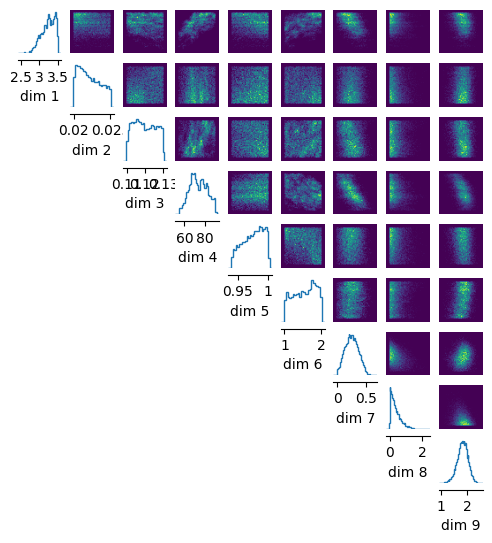

In [7]:
_ = pairplot(samples,
             # limits=[[-2, 2], [-2, 2], [-2, 2]],
             figsize=(6, 6),)
             # labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"])

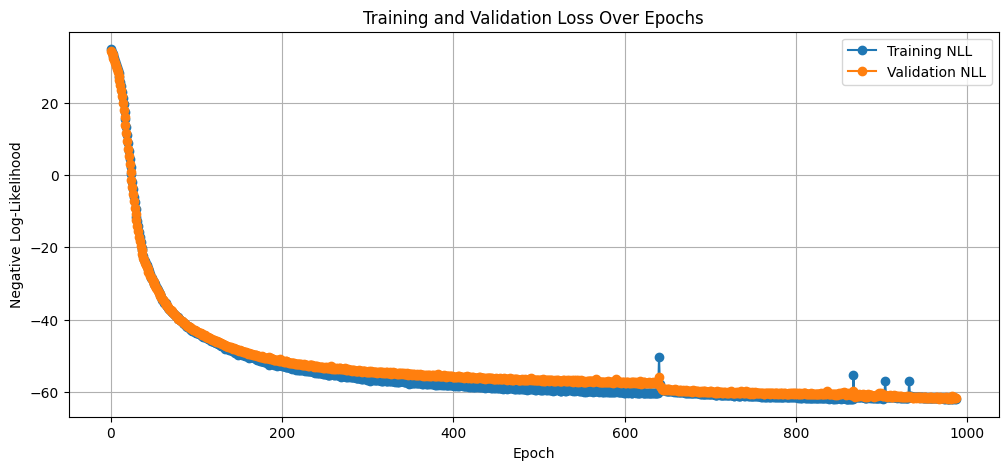

In [8]:
# --- Plotting Loss Curves ---
train_loss_history = inference._summary["training_loss"]
val_loss_history = inference._summary["validation_loss"]

plt.figure(figsize=(12, 5))
plt.plot(train_loss_history, label="Training NLL", marker="o")
plt.plot(val_loss_history, label="Validation NLL", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Negative Log-Likelihood")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)


In [9]:
from sbi.neural_nets.estimators.shape_handling import reshape_to_batch_event

def compute_log_likelihoods(inference_obj, theta, x):
    """
    Compute log likelihood values for a batch using the trained neural likelihood estimator.
    If theta and x already have matching batch dimensions, use them directly.
    """
    inference_obj._neural_net.eval()
    with torch.no_grad():
        # Check if the batch dimensions already match.
        if theta.shape[0] == x.shape[0]:
            # Use the tensors as they are.
            log_liks = inference_obj._neural_net.log_prob(x, condition=theta)
        else:
            # Otherwise, reshape using the network's expected event shapes.
            from sbi.neural_nets.estimators.shape_handling import reshape_to_batch_event
            theta_reshaped = reshape_to_batch_event(theta, event_shape=inference_obj._neural_net.condition_shape)
            x_reshaped = reshape_to_batch_event(x, event_shape=inference_obj._neural_net.input_shape)
            log_liks = inference_obj._neural_net.log_prob(x_reshaped, condition=theta_reshaped)
    return log_liks



# For example, use the last round's simulations as a hold-out batch:
# theta_holdout = torch.load("theta_round5_1k.pt")
# x_holdout = torch.load("x_round5_1k.pt")
theta_holdout = torch.load(f"sbi_sim_data/theta_1ksamps.pt")
x_holdout = torch.load(f"sbi_sim_data/x_1ksamps.pt")
print(theta_holdout.shape, x_holdout.shape)
print(inference)
# Compute the log-likelihoods (or negative log likelihoods)
log_likelihoods = compute_log_likelihoods(inference, theta_holdout, x_holdout)
nll_values = -log_likelihoods  # negative log likelihoods

plt.subplot(1, 2, 2)
plt.hist(nll_values, bins=30, color="skyblue", edgecolor="k")
plt.xlabel("Negative Log-Likelihood")
plt.ylabel("Frequency")
plt.title("Histogram of NLL on Hold-Out Batch")
plt.grid(True)

plt.tight_layout()
plt.show()

torch.Size([1000, 9]) torch.Size([1000, 18])


/tmp/ipykernel_2421859/990941076.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  theta_holdout = torch.load(f"sbi_sim_data/theta_1ksamps.pt")
/tmp/ipykernel_2421859/990

AssertionError: Batch shape of condition 1000 and input 18 do not match.